In [1]:
#  given list to get c , c2 c,3...
import numpy as np
import random
import pickle
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#open Cliff_indices1 put into data
with open("Cliff_indices_4.pkl", "rb") as f:  
    data = pickle.load(f)
f.close()

#open Prim put into Prim
with open("Prim_exp.pkl", "rb") as f2:  
    Prim = pickle.load(f2)
f2.close()

#open Prim_inv put into Prim_inv
with open("Inverse_of_prim.pkl", "rb") as f3:  
    Prim_inv = pickle.load(f3)
f3.close()

with open("Prim_perfect.pkl", "rb") as f4:  
    Prim_perfect = pickle.load(f4)
f4.close() 

####################################################initial state#############################################################
#given probability  NOT Probability amplitude
#[target , ud , du , dd]
e_ud=0.01                 #error probability  NOT Probability amplitude
e_du=0                  
e_dd=0
    
def error_initial_state(e1,e2,e3):
    return np.matrix([[math.sqrt(1-e1*e1-e2*e2-e3*e3),math.sqrt(e1),math.sqrt(e2),math.sqrt(e3)]]).getH()
initial = error_initial_state(e_ud,e_du,e_dd)

####################################################initial state#############################################################
#############################################Randomized Benchmarking##########################################################
#given list , return s = c0*c1*c2....

def Is_Inverse(A, B):
    if np.allclose(np.absolute(np.trace(np.dot(A, B))), 4):
        return True
    else:
        return False
    
def fidelity(M_exp, M):
    return np.absolute(np.trace(np.dot(M_exp.conj().T, M)))/4

def get_s(g1):               
    p = np.identity(4)                             # 計數器for p@p1@p2....
    for i in range(len(g1)):
        array = g1[i]
        for j in range(len(array)):
            p = p@Prim[array[j]]                  #s=p*p*p*p*p*p*p....
    return p

def get_s_perfect(g1):               
    p = np.identity(4)                             # 計數器for p@p1@p2....
    for i in range(len(g1)):
        array = g1[i]
        for j in range(len(array)):
            p = p@Prim_perfect[array[j]]                  #s=p*p*p*p*p*p*p....
    return p

def get_perfect_unitary(seq):                 #Get perfect gate from decomposition info. in "Cliff_indices_4.pkl"
    p = np.identity(4)                             
    for j in range(len(seq)):
        p = p@Prim_perfect[seq[j]]                  
    return p


def get_nonperfect_unitary(seq):                 #Get perfect gate from decomposition info. in "Cliff_indices_4.pkl"
    p = np.identity(4)                             
    for i in range(len(seq)):
        p = p@Prim[seq[i]]                  
    return p

#given list , return c^-1 
def c_m(c1):
    a = get_s_perfect(c1)
    for k in range(len(data)):
        b = get_perfect_unitary(data[k])
        if Is_Inverse(a, b):
            return get_nonperfect_unitary(data[k])

l1 = np.arange(1,20,1)
l2 = np.arange(20, 40, 2)
l3 = np.arange(40, 65, 5)
x = np.hstack((l1, l2, l3))
I = np.identity(4)

y = []
yerr = []

N = 10                                              # samples for each data point (算標準差即是使用每個data point對應的N個數據)
K = 51                                           # of S sequence 相同長度 重複取k次

for m in x:
    results = []
    for n in range(N):
        num_uu = 0
        print("L = ", m, "; data", n+1, "is calculating...")
        for i in range(K):
            list2 = random.choices(data,k=m)               #data 隨便可重複取m個
            seq_k = get_s(list2)@c_m(list2)          # k_th seq
#             print(fidelity(seq_k, I))

#############################################Randomized Benchmarking##########################################################
#############################################Readout##########################################################################
            e_readout=0.05
            final_prob=np.square(np.abs(seq_k@initial))
            err = final_prob[0]*e_readout
            final_prob[0] -= err   #這邊是否會造成機率不守恒? 只有uu態機率因readout減少但其他態機率沒變?
            for i in range(1, 4): final_prob[i] += err/3
            uu_count=[1,0,0,0]
            a=random.choices(uu_count,weights=final_prob, k=1)
            num_uu=num_uu+a[0]
        results.append(num_uu/K)
    y.append(np.mean(results))
    yerr.append(np.std(results))

#saveing the results
f5 = open('2q_RB_simu_L.pkl', 'wb')
pickle.dump(x , f5)
f5.close()    

f6 = open('2q_RB_simu_y.pkl', 'wb')
pickle.dump(y , f6)
f6.close()  

f7 = open('2q_RB_simu_yerr.pkl', 'wb')
pickle.dump(yerr , f7)
f7.close()  
# Fitting function

def func(x, A, B, r):
    return A * (1 - 4/3*r)**x + B

# def func(x, A):
#     return  * (1 - 4/3*0.053)**x + 0.25

popt, pcov = curve_fit(func, x, y, p0=[1, 0, 0], bounds = (0, 1), maxfev = 5000)      
#p0 is the guess of the parameters. Guess B ~ 0 (ideally be 0.25) and r ~ 0 (no noise model now so r should be ultra low)



print("F_Ciff = 1 - r = ", 1-popt[2])
print("A = ", popt[0])
print("B = ", popt[1])

plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=4, capsize=3)
plt.plot(x, func(x, *popt), 'r-')
# plt.plot(x, func(x, 0.75, 0.25, 0.053), 'b-')
plt.ylim(top=1.0)
plt.xlabel("Number of Cliffords (L)")
plt.ylabel("Proj. State Prob.")
plt.title("Two-qubit RB Fitting")



L =  1 ; data 1 is calculating...
L =  1 ; data 2 is calculating...
L =  1 ; data 3 is calculating...
L =  1 ; data 4 is calculating...
L =  1 ; data 5 is calculating...
L =  1 ; data 6 is calculating...
L =  1 ; data 7 is calculating...
L =  1 ; data 8 is calculating...
L =  1 ; data 9 is calculating...
L =  1 ; data 10 is calculating...
L =  2 ; data 1 is calculating...
L =  2 ; data 2 is calculating...
L =  2 ; data 3 is calculating...
L =  2 ; data 4 is calculating...
L =  2 ; data 5 is calculating...
L =  2 ; data 6 is calculating...
L =  2 ; data 7 is calculating...
L =  2 ; data 8 is calculating...
L =  2 ; data 9 is calculating...
L =  2 ; data 10 is calculating...
L =  3 ; data 1 is calculating...
L =  3 ; data 2 is calculating...
L =  3 ; data 3 is calculating...
L =  3 ; data 4 is calculating...
L =  3 ; data 5 is calculating...
L =  3 ; data 6 is calculating...
L =  3 ; data 7 is calculating...
L =  3 ; data 8 is calculating...
L =  3 ; data 9 is calculating...
L =  3 ; dat

L =  28 ; data 7 is calculating...
L =  28 ; data 8 is calculating...
L =  28 ; data 9 is calculating...
L =  28 ; data 10 is calculating...
L =  30 ; data 1 is calculating...
L =  30 ; data 2 is calculating...
L =  30 ; data 3 is calculating...
L =  30 ; data 4 is calculating...
L =  30 ; data 5 is calculating...
L =  30 ; data 6 is calculating...
L =  30 ; data 7 is calculating...
L =  30 ; data 8 is calculating...
L =  30 ; data 9 is calculating...
L =  30 ; data 10 is calculating...
L =  32 ; data 1 is calculating...
L =  32 ; data 2 is calculating...
L =  32 ; data 3 is calculating...
L =  32 ; data 4 is calculating...
L =  32 ; data 5 is calculating...
L =  32 ; data 6 is calculating...
L =  32 ; data 7 is calculating...
L =  32 ; data 8 is calculating...
L =  32 ; data 9 is calculating...
L =  32 ; data 10 is calculating...
L =  34 ; data 1 is calculating...
L =  34 ; data 2 is calculating...
L =  34 ; data 3 is calculating...
L =  34 ; data 4 is calculating...
L =  34 ; data 5 

Text(0.5, 1.0, 'Two-qubit RB Fitting')

F_Ciff = 1 - r =  0.95997710410578
A =  0.7002691799301273
B =  0.23788407153355928


Text(0.5, 1.0, 'Two-qubit RB Fitting')

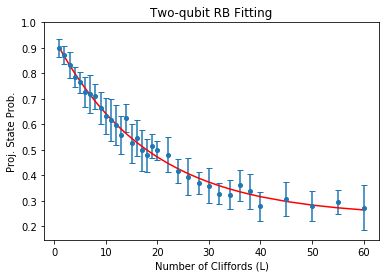

In [2]:
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

with open("2q_RB_simu_L.pkl", "rb") as f:  
    x = pickle.load(f)
f.close()

with open("2q_RB_simu_y.pkl", "rb") as f:  
    y = pickle.load(f)
f.close()

with open("2q_RB_simu_yerr.pkl", "rb") as f:  
    yerr = pickle.load(f)
f.close()


def func(x, A, B, r):
    return A * (1 - 4/3*r)**x + B

popt, pcov = curve_fit(func, x, y, p0=[1, 0, 0], bounds = (0, 1), maxfev = 5000)      
#p0 is the guess of the parameters. Guess B ~ 0 (ideally be 0.25) and r ~ 0 (no noise model now so r should be ultra low)

print("F_Ciff = 1 - r = ", 1-popt[2])
print("A = ", popt[0])
print("B = ", popt[1])
plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=4, capsize=3)
plt.plot(x, func(x, *popt), 'r-')
# plt.plot(x, func(x, 0.75, 0.25, 0.053), 'b-')
plt.ylim(top=1.0)
plt.xlabel("Number of Cliffords (L)")
plt.ylabel("Proj. State Prob.")
plt.title("Two-qubit RB Fitting")